# Various analyses for NP optimization study by Wahl et al.
This notebook includes code for generating:
* Plots dispplaying different statistical aspects of collected NP data.
* Various performance tests for machine learning models using the designed descriptor+PCA based embedding. 

Let's import required libraries and prepare our dataset:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import GPy
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.linear_model import ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

from matminer.featurizers.composition import ElementProperty
from nanoparticle_project import get_comps

path = os.getcwd()
df = pd.read_csv('megalibrary_data.csv')
for col in ['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pt%', 'Pd%', 'Sn%']:
    df[col] = df[col]/100.0
df = df.sample(frac=1, random_state=42) # shuffling the dataframe
df['target'] = -1*np.abs(df["Interfaces"]-1)
df = df[~df.duplicated()]
df['Composition'] = df.apply(get_comps,axis=1)
df['n_elems'] = (df[['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pt%', 'Pd%', 'Sn%']]>0).sum(axis=1)

### Nanoparticle dataset

In [2]:
plot_df = df[['Interfaces', 'n_elems']]
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
colormap=ListedColormap(sns.color_palette("magma", 6))

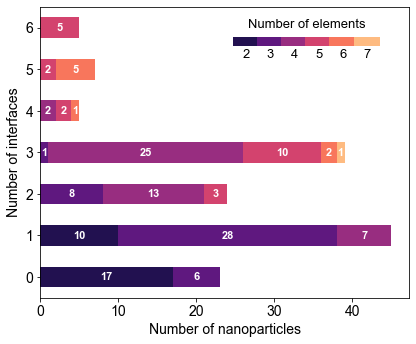

In [3]:
fig=plt.figure(figsize=(6,5))
ax = plot_df.groupby(['Interfaces','n_elems']).size().unstack().plot(kind='barh',
                                                                     stacked=True, rot=90, colormap=colormap,
                                                                     ax=plt.gca(), **{'lw':1})
ax.set_ylabel('Number of interfaces')
ax.set_xlabel('Number of nanoparticles')
plt.yticks(rotation = 0)

for rect in ax.patches:
    h = rect.get_height()
    w = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    txt = f'{w:.0f}' 
    l_x = x + w/2
    l_y = y + h/2
    if w > 0:
        ax.text(l_x, l_y, txt, ha='center', va='center', fontsize=11, color='w', fontweight='bold')

legend = plt.legend(title='Number of elements',
           frameon=False, edgecolor='k', 
           fontsize=13,ncol=6, columnspacing=-1.5)

legend.get_title().set_position((-8, 0))
plt.setp(legend.get_title(),fontsize=13)

for txt in legend.get_texts():
    txt.set_ha("center")
    txt.set_x(-23)
    txt.set_y(-12)
plt.tight_layout()
plt.savefig('particle_dist_1.pdf',dpi=300)
plt.savefig('particle_dist_1.png',dpi=300)

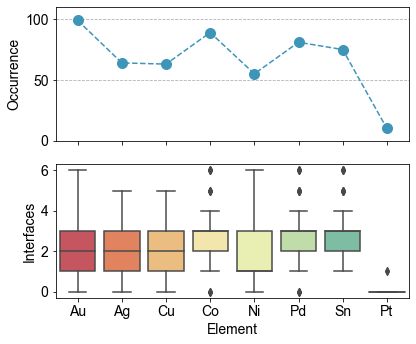

In [4]:
css = list(sns.color_palette('Spectral', n_colors=7))
elements = ['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pd%', 'Sn%','Pt%']
frames = []
for el in elements:
    lbl = el.split('%')[0]
    _d=df[ df[el]>0 ]
    _d['Element'] = lbl
    frames.append(_d[['Element','Interfaces']])
data = pd.concat(frames)

fig2,axes2 =plt.subplots(nrows=2, figsize=(6,5),sharex=True)
box = sns.boxplot(x='Element', y='Interfaces', data=data, palette='Spectral',ax=axes2[1])

axes2[1].set_ylabel('Interfaces')

distrib = data.groupby('Element').size()

x = list(range(8))
y = []
for t in box.xaxis.get_ticklabels():
    y.append( distrib[ t.get_text()])

ax_dist = axes2[0]
ax_dist.grid(True,which='both',axis='y',linestyle='--')
ax_dist.plot(x,y,'o--',ms=10,color=css[-1])
ax_dist.tick_params(axis='both', which='both')

ax_dist.set_ylim(0,110)
ax_dist.set_ylabel('Occurrence')

plt.tight_layout()
plt.savefig('particle_dist_2.pdf',dpi=300)
plt.savefig('particle_dist_2.png',dpi=300)

### Model testing

Here we test a linear (ElasticNet) and GP model in predicting our target, and compare the effect 
of using composition directly as input to using descriptor+PCA route.  Let's now featurize our data to create our descriptors from the compositions

In [5]:
ep = ElementProperty.from_preset(preset_name='magpie')
featurized_df = ep.featurize_dataframe(df[ ['Composition','target'] ],'Composition').drop('Composition',axis=1)
X = featurized_df.drop('target',axis=1)
y = df.target

ElementProperty:   0%|          | 0/148 [00:00<?, ?it/s]

We will do 10-fold cross-validation throughout:

In [6]:
nfold=10

Let's first measure the performance ElasticNet model using the composition as input in predicting our target:

In [7]:
steps = [("ML", ElasticNetCV(random_state=42, cv=nfold, max_iter=5000,tol=1e-5))]
pipeline = Pipeline(steps)

enet_cv_scores = cross_val_score(
    pipeline,
    df[['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pt%', 'Pd%', 'Sn%']],
    df.target,
    cv=KFold(nfold, shuffle=True, random_state=42),
    scoring="neg_mean_absolute_error",
)
enet_cv_score = np.mean(enet_cv_scores) * -1
enet_cv_std = np.std( np.array(enet_cv_scores)* -1)

Now we will measure the performance of ElasticNet trained on the composition-derived descriptors (X above) + PCA as a function of number of principal components (N_pca):

In [8]:
n_pca = [1,5,10,15,20,25,30,35,40,45,50,60]
elastic_net_pca = []
for i in n_pca:
    steps = [("scaler", StandardScaler()), 
             ("pca", PCA(n_components=i)), 
             ("ML", ElasticNetCV(random_state=42,
                                 cv=10, max_iter=5000,tol=1e-5))]
    pipeline = Pipeline(steps)

    cv_scores = cross_val_score(
        pipeline,
        X,
        y,
        cv=KFold(nfold, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring="neg_mean_absolute_error",
    )
    cv_score = np.mean(cv_scores) * -1
    elastic_net_pca.append(cv_scores*-1)
means = np.mean(elastic_net_pca, axis=1)
stds = np.std(elastic_net_pca, axis=1)

Now we are going to try a Gaussian Process model with RBF kernel to predict our target. Let's first look at the performance of this model on predicting directly using composition as input:

In [9]:
true,pred=[],[]
kf=KFold(nfold, shuffle=True, random_state=42)
elts = ['Au%', 'Ag%', 'Cu%', 'Co%', 'Ni%', 'Pt%', 'Pd%', 'Sn%']
for i,j in kf.split(df,df.target):
    # train data for this split
    _X=df[elts].iloc[i] 
    _y=df.Interfaces.iloc[i].to_numpy().reshape(-1, 1)
    # test data for this split
    _Xt=df[elts].iloc[j]
    _yt=df.Interfaces.iloc[j].to_numpy().reshape(-1, 1)
    
    scaler = StandardScaler()
    scalery = StandardScaler()
    X_scaled = scaler.fit_transform(_X)
    y_scaled = scalery.fit_transform(_y)
    kernel = GPy.kern.RBF(input_dim=_X.shape[1])
    m = GPy.models.GPRegression(
                                X_scaled,
                                y_scaled,
                                kernel=kernel,
                                noise_var=1.0,
                )
    m.optimize(optimizer="bfgs", max_iters=5000)
    y_pred, var = m.predict(scaler.transform(_Xt))
    y_pred = scalery.inverse_transform(y_pred)
    true+=_yt.tolist()
    pred+=y_pred.tolist()
gp_cv_score = np.mean(np.abs(np.array(true)-np.array(pred)))
gp_cv_std = np.std(np.abs(np.array(true)-np.array(pred)))

Here we will measure the performance of the GP-RBF model, this time on the descriptor+PCA as input, and as a function of N_pca. We'll do a 10-fold CV again for each N_pca we try:

In [10]:
gp_pca = []
for p in n_pca:
    kf=KFold(nfold, shuffle=True, random_state=42)
    _local=[]
    for i,j in kf.split(X,y):
        # train data for this split
        _X=X.iloc[i]
        _y=y.iloc[i].to_numpy().reshape(-1, 1)
        # test data for this split
        _Xt=X.iloc[j]
        _yt=y.iloc[j].to_numpy().reshape(-1, 1)
        
        scaler = StandardScaler()
        scalery = StandardScaler()
        X_scaled = scaler.fit_transform(_X)
        y_scaled = scalery.fit_transform(_y)
        pca = PCA(n_components=p)
        X_pca = pca.fit_transform(X_scaled)
        kernel = GPy.kern.RBF(input_dim=p)
        m = GPy.models.GPRegression(
                                    X_pca,
                                    y_scaled,
                                    kernel=kernel,
                                    noise_var=1.0,
                    )
        m.optimize(optimizer="bfgs", max_iters=5000)
        y_pred, var = m.predict(pca.transform(scaler.transform(_Xt)))
        y_pred = scalery.inverse_transform(y_pred)
        _local.append(np.mean(np.abs(_yt.reshape(-1)-y_pred.reshape(-1))))
    gp_pca.append(_local)
    
means_gp = np.mean(gp_pca, axis=1)
stds_gp = np.std(gp_pca, axis=1)

In [11]:
means_gp, stds_gp

(array([0.74543375, 0.53948459, 0.54758199, 0.52978375, 0.52119919,
        0.5113058 , 0.51000775, 0.50856988, 0.50837173, 0.50823012,
        0.50837648, 0.50884455]),
 array([0.15518437, 0.06721427, 0.08943109, 0.08588211, 0.08468426,
        0.08516475, 0.0875689 , 0.0871304 , 0.08682468, 0.08649443,
        0.08635841, 0.08628952]))

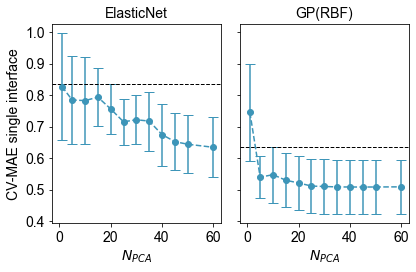

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,4))
axes[0].errorbar(x=n_pca, y=means, yerr=stds,fmt='--o',capsize=5,label='ElasticNet(feat.)',color=css[-1])
axes[1].errorbar(x=n_pca, y=means_gp, yerr=stds_gp,fmt='--o',capsize=5,label='GP(feat.)',color=css[-1])

axes[0].plot([-3,63],[enet_cv_score, enet_cv_score],'k--',label='ElasticNet(comp.)', linewidth=1,)

axes[1].plot([-3,63],[gp_cv_score, gp_cv_score],'k--',label='GP(comp.)', linewidth=1)


axes[0].set_xlim([-3,63])
axes[1].set_xlim([-3,63])
axes[0].set_xlabel("$N_{PCA}$")
axes[1].set_xlabel("$N_{PCA}$")
axes[0].set_ylabel("CV-MAE single interface")
axes[0].set_title('ElasticNet',fontsize=14)
axes[1].set_title('GP(RBF)',fontsize=14)
fig.subplots_adjust(wspace=0.06)
plt.tight_layout()
plt.savefig('model_pca_1.pdf',dpi=300)
plt.savefig('model_pca_1.png',dpi=300)

We see above that (i) GP is overall much better than the ElasticNet here, and (ii) performance gains beyond N_pca=20 is minimal, hence we will use 20 principal components in our BO study.

Finally, we want to test how our GP(RBF) model with the deisgned descriptor+PCA input route (with N_pca=20) improves its performance with incoming data (I model can keep improving within the data regimes we are looking at), which is important for BO.

In [13]:
n_data = [30, 40, 50, 60, 80, 100, 120, 148]
leaning_gp = []
for h in n_data:
    _local = []
    kf=KFold(nfold, shuffle=True, random_state=42)
    for i,j in kf.split(X.head(h),y.head(h)):
        # train data for this split
        _X=X.iloc[i]
        _y=y.iloc[i].to_numpy().reshape(-1, 1)
        # test data for this split
        _Xt=X.iloc[j]
        _yt=y.iloc[j].to_numpy().reshape(-1, 1)
        scaler = StandardScaler()
        scalery = StandardScaler()
        X_scaled = scaler.fit_transform(_X)
        y_scaled = scalery.fit_transform(_y)
        pca = PCA(n_components=20)
        X_pca = pca.fit_transform(X_scaled)
        kernel = GPy.kern.RBF(input_dim=20)
        m = GPy.models.GPRegression(
                                    X_pca,
                                    y_scaled,
                                    kernel=kernel,
                                    noise_var=1.0,
                    )
        m.optimize(optimizer="bfgs", max_iters=5000)
        y_pred, var = m.predict(pca.transform(scaler.transform(_Xt)))
        y_pred = scalery.inverse_transform(y_pred)
        _local.append(np.mean(np.abs(_yt.reshape(-1)-y_pred.reshape(-1))))
    leaning_gp.append(_local)
means_gp_learning = np.mean(leaning_gp, axis=1)
stds_gp_learning = np.std(leaning_gp, axis=1)

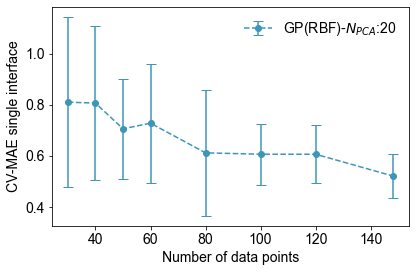

In [14]:
plt.errorbar(n_data,means_gp_learning,yerr=stds_gp_learning, capsize=5, fmt='--o',label='GP(RBF)-$N_{PCA}$:20',color=css[-1])
plt.xlabel('Number of data points')
plt.ylabel('CV-MAE single interface')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('model_pca_2.pdf',dpi=300)
plt.savefig('model_pca_2.png',dpi=300)